In [1]:
#Import needed packages
import pandas as pd

#Import model and visualization functions
import sys 
sys.path.append('../src/models')
sys.path.append('../src/visualization')
sys.path.append('../src/data')
from support_vector_machine import support_vector_machine
from randomforest_classifier import randomforest_classifier
from decision_tree_classifier import decision_tree_classifier
from plot_results import plot_results
from combine_tables import combine_tables

#Import our data
log_returns_currencies = pd.read_csv("../data/processed/log_returns_currency_data.csv")
log_returns_spx = pd.read_csv("../data/processed/log_returns_spx_data.csv")
dataframe = pd.merge(log_returns_currencies, log_returns_spx.iloc[1:], on='DATE', how='inner')
print(dataframe)

            DATE   USDEUR   USDJPY   USDGBP   USDCHF   USDAUD   USDCAD  \
0     2013-11-05  0.00341  0.00020 -0.00588 -0.00219  0.00242 -0.00316   
1     2013-11-06 -0.00444  0.00000 -0.00224  0.00186 -0.00326  0.00278   
2     2013-11-07  0.01040  0.00041  0.00068 -0.00820  0.00516 -0.00221   
3     2013-11-08  0.00247 -0.00476  0.00462 -0.00391  0.00934 -0.00430   
4     2013-11-12 -0.00530 -0.00624  0.00495  0.00478  0.00975 -0.00133   
...          ...      ...      ...      ...      ...      ...      ...   
2478  2023-10-23 -0.00509  0.00047 -0.00672 -0.00011 -0.00284  0.00117   
2479  2023-10-24  0.00480 -0.00040  0.00533 -0.00179 -0.00189 -0.00496   
2480  2023-10-25  0.00113 -0.00067  0.00247 -0.00179  0.00237 -0.00204   
2481  2023-10-26  0.00483 -0.00333  0.00223 -0.00490  0.00348 -0.00420   
2482  2023-10-27 -0.00568  0.00560 -0.00313 -0.00289 -0.00632 -0.00260   

       USDNZD   USDSEK   USDSGD   USDNOK    SP500  
0    -0.00133 -0.00402 -0.00064 -0.00557 -0.00281  
1    -0

In [2]:
#Select the number of days lag for our models
lag = 1
#Choose whether to use a random seed when training the models, if random_seed is false, standard_seed is used
random_seed = False
#Select the size of the training dataset (%)
train_size = 0.8
#Specify which currencies to use in the analysis
currencies = ['USDEUR', 'USDJPY', 'USDGBP', 'USDCHF', 'USDAUD', 'USDCAD', 
              'USDNZD', 'USDSEK', 'USDSGD', 'USDNOK']
#Choose whether S&P 500 should be used as a regressor variable
include_sp500 = False
#Should the strategy be long only?
long_only = False

In [3]:
#Train the models and print their accuracies
svm_accuracies, svm_results = support_vector_machine(dataframe, currencies, include_sp500, lag, train_size, random_seed, long_only)
rf_accuracies, rf_results = randomforest_classifier(dataframe, currencies, include_sp500, lag, train_size, random_seed, long_only)
dt_accuracies, dt_results = decision_tree_classifier(dataframe, currencies, include_sp500, lag, train_size, random_seed, long_only)

             in sample  out of sample
Classifiers                          
SVC           0.608564       0.376258
             in sample  out of sample
Classifiers                          
RFC           0.608564       0.372233
             in sample  out of sample
Classifiers                          
DTC           0.671033       0.261569


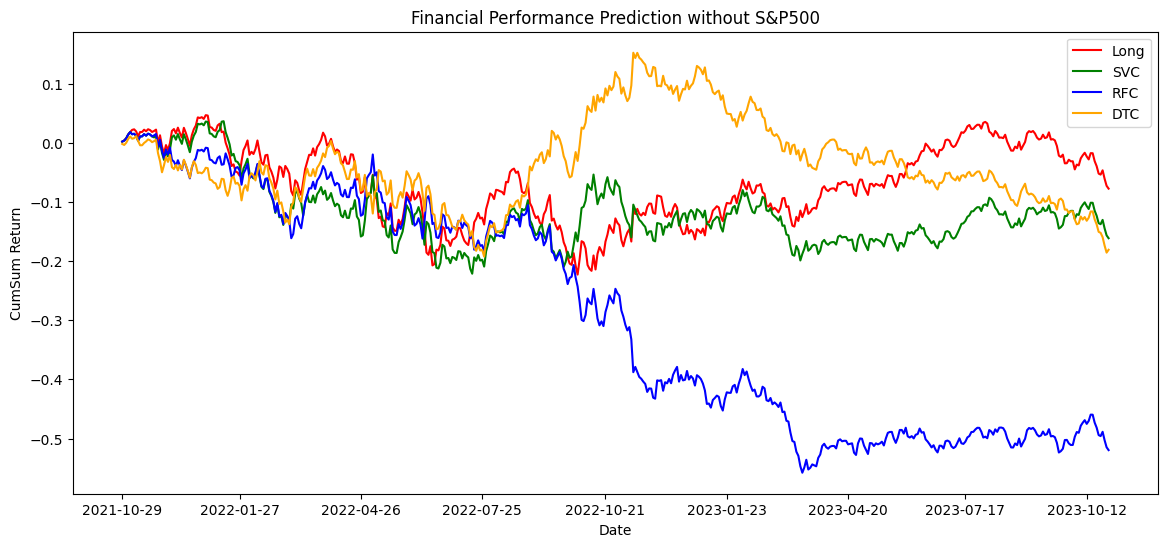

In [4]:
results = combine_tables([svm_results, rf_results, dt_results])
#Combine results tables
#result_df = pd.merge(svm_results, dt_results, on='ID')
#Plot the results
plot_results(results, include_sp500)
